# Preliminary

In [18]:
!pip install torchinfo
!pip install --q huggingface_hub
!pip install --q transformers -U
!pip install --q sentencepiece

In [19]:
import numpy as np                  # just in case
import pandas as pd                 # for extracting info

import zipfile                      # for extracting photos from zip
from PIL import Image
from io import StringIO

import torch                        
import torch.nn as nn               
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from torchinfo import summary  

import matplotlib.pyplot as plt

## Parameters

In [20]:
# global variables 
img_size = 256              # assuming square images -> subject to change
img_channels = 3           # assuming RGB images 
num_outputs = 1             # we want a single number signifying the rating
batch_size = 64

# filepath = '/content/drive/MyDrive/EngSci Y3 Winter/YelpProject'    # this is the original filepath (vince)
filepath = '/content/drive/MyDrive/YelpProject'                             # use this for the shared account

# a small check to make sure the GPU is available:
# DISABLE IN COLAB WHEN NOT USING 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Extraction

The Yelp Database (uploaded to Drive) is extracted to a pandas dataframe for input into the proposed neural networks shown below.

## Dataframe

In [22]:
yelp_data = pd.read_json(f'{filepath}/foodEntriesWithReviews.json')
yelp_data['reviews'].hasnans

True

In [23]:
yelp_data = yelp_data.dropna().reset_index()
yelp_data.head()

,index,photo_id,business_id,caption,label,rating,reviews
0,0,lZlulVObEzvCRhEmJAq-7A,2bncbx08BFs_IO6H-yWBxw,Dim sum! Turnip pancake,food,3.0,[[Chinatown is flush with Chinese restaurants ...
1,1,XvO6tewa1-gH20GIUtvQTA,qUY04I5gDm5uyInd1mCizg,"If you're into wicked good food\, go ahead.",food,4.0,[[the cutest place ever! We were visiting and ...
2,2,qTOGkJNCgdcD1GalYG6bZw,SAP7Myf72pKvEc54Zl45vQ,,food,3.5,[[I started looking this place up on yelp and ...
3,3,mwWW3GSErVOsSsR3GQ5CLg,VrlJifUE36-U_OaiipGexA,,food,4.0,[[This place is pretty good I would say. It di...
4,4,GyGbnJ9cwCe80fGYr9ZdRA,BujhETG-6POYdsi_8I_MBg,,food,3.5,"[[Really really hit the spot, dreaming of a go..."


In [24]:
yelp_data['reviews'].hasnans

False

## Text Reviews and Ratings

In [25]:
# taking a closer look at the text reviews:
yelp_data.iloc[8]['reviews']

[['If you are looking for a sweet treat at Harvard Square definitely stop into milk bar... This is one of our favorite shops when we visit New York City so we...',
  4],
 ["I don't understand what the hype is about. I got a slice of their apple cider doughnut cake. There were layers of hard frosting and spiced apple jam, and...",
  2],
 ["Don't understand the hype of this place. Got the crunchy cereal milk shake, it was boring and nothing special. The soft serve flavor of the month was funnel...",
  2]]

In [26]:
reviews = []
ratings = []

for block_review in yelp_data['reviews']:
    if block_review:
        for review in block_review:
            reviews.append(review[0])
            ratings.append(review[1])

reviews = np.array(reviews)         
ratings = np.array(ratings)

print(f'sample review: {reviews[0]}')
print(f'corresponding rating: {ratings[0]}')
print(f'number of reviews/ratings: {ratings.size}')

sample review: Chinatown is flush with Chinese restaurants densely packed on every block - most of which, in my opinion at least, have adapted strongly to the American...
corresponding rating: 4
number of reviews/ratings: 89340


## Images

In [27]:
zip_obj = zipfile.ZipFile(f'{filepath}/foodPhotos.zip', mode='r')
zip_obj.namelist()[0:5]                 # small look into our namelist

['foodPhotos/',
 'foodPhotos/-5zFb3OJT40b_y1y-OYm3g.jpg',
 '__MACOSX/foodPhotos/._-5zFb3OJT40b_y1y-OYm3g.jpg',
 'foodPhotos/3HCtnuCU-fAyedmUldVNNA.jpg',
 '__MACOSX/foodPhotos/._3HCtnuCU-fAyedmUldVNNA.jpg']

Here is a sample image


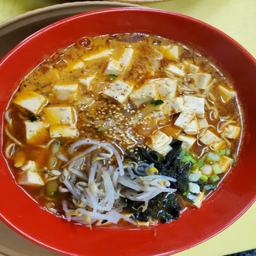

In [28]:
# a sample extraction
img_file = zip_obj.open(f'{zip_obj.namelist()[3]}')
img = Image.open(img_file)
img = img.resize((img_size, img_size))

print("Here is a sample image")
img

In [29]:
# we can convert the image to numpy array -> tensor:
img_sample_tensor = torch.tensor(np.array(img)).to(device)
img_sample_tensor = img_sample_tensor.float()
img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front
img_sample_tensor = torch.unsqueeze(img_sample_tensor, 0)
img_sample_tensor.shape

torch.Size([1, 3, 256, 256])

## Complete Image Extraction

**NOTE:** This section is completely deprecated in favour of dataloaders (do NOT run!)

In [30]:
# # now to get all of the images
# yelp_imgs = []

# for id in yelp_data['photo_id']:
#     temp_path = f'{zip_obj.namelist()[0]}{id}.jpg'
#     img_file = zip_obj.open(temp_path)
#     img = Image.open(img_file)
#     img = img.resize((img_size, img_size))
#     yelp_imgs.append(img)

In [31]:
# yelp_imgs = np.array(yelp_imgs)
# print(yelp_imgs)

# Text Data Prep

## Tokenizer and Embedding Model

In this section, we declare our embedding model which will be used to train our image-to-embedding CNN. This is done using the `HuggingFace` package, which features a pretrained BERT model.

In [32]:
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-cased')

text_1 = "Who was Jim Henson ?"
text_2 = "Jim Henson was a puppeteer"

# Tokenized input with special tokens around it (for BERT: [CLS] at the beginning and [SEP] at the end)
indexed_tokens = tokenizer.encode(text_1, text_2, add_special_tokens=True)

Downloading: "https://github.com/huggingface/pytorch-transformers/archive/main.zip" to /root/.cache/torch/hub/main.zip


Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

In [33]:
segments_ids = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
segments_tensors = torch.tensor([segments_ids])
tokens_tensor = torch.tensor([indexed_tokens])

# get our model
bert_model = torch.hub.load('huggingface/pytorch-transformers', 'model', 'bert-base-cased')

Using cache found in /root/.cache/torch/hub/huggingface_pytorch-transformers_main


Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
# move our model to device
bert_model = bert_model.to(device)

In [35]:
data_extracted = np.array(yelp_data['reviews'].values)
for i in range(0, data_extracted.shape[0]):
    data_extracted[i] = np.array(data_extracted[i])

data_extracted = data_extracted.flatten()

In [36]:
# a sample tokenizer output:
test_token = tokenizer.encode(reviews[0], add_special_tokens=True)
token_tensor = torch.tensor([test_token]).to(device)

with torch.no_grad():
    test_embed = bert_model(token_tensor)[1]

print(f'Embedding vector produced with dimensionality: {test_embed.shape}')

Embedding vector produced with dimensionality: torch.Size([1, 768])


## Test/Train/Validation Splitting

In [37]:
reviews_train, reviews_test, ratings_train, ratings_test = train_test_split(reviews, ratings, test_size = 0.3)
reviews_test, reviews_valid, ratings_test, ratings_valid = train_test_split(reviews_test, ratings_test, test_size=0.33)

print(f'review train/test/valid sizes: {reviews_train.size}/{reviews_test.size}/{reviews_valid.size}')
print(f'review train/test/valid sizes: {ratings_train.size}/{ratings_test.size}/{ratings_valid.size}')

review train/test/valid sizes: 62538/17957/8845
review train/test/valid sizes: 62538/17957/8845


## Text Embedding Dataloaders

Pytorch's DataLoaders let us define large datasets that can be processed from files as inputs to our model. Data loading is GPU parallelizable, which is a necessity given the size of our dataset.

In [38]:
# now, we convert all text to embeddings as necessary:
# pytorch's dataloader class will handle parallelization for us
class embedding_data(Dataset):
    def __init__(self, tokenizer=None, model=None, reviews=None, ratings=None, device=device):
        self.tokenizer = tokenizer
        self.model = model
        self.reviews = reviews
        self.ratings = ratings

    def __len__(self):
        return self.reviews.size

    def __getitem__(self, idx):
        token = self.tokenizer.encode(self.reviews[idx], add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        rating = ratings[idx]

        return embed, rating

In [67]:
bert_data_train = embedding_data(tokenizer, bert_model, reviews_train)
bert_data_test = embedding_data(tokenizer, bert_model, reviews_test)
bert_data_valid = embedding_data(tokenizer, bert_model, reviews_valid)
print(f'This is a dataset dimension: {bert_data_train[0][0].shape}\n')

bert_loader_train = DataLoader(bert_data_train, batch_size=batch_size)
bert_loader_test = DataLoader(bert_data_test, batch_size=batch_size)
bert_loader_valid = DataLoader(bert_data_valid, batch_size=batch_size)
sample_bert_iterator = iter(bert_loader_train)

# a sample of our embedding loader (by iterating through it)
temp = next(sample_bert_iterator)
print(f'This is the dimensionality of a dataloader batch: {temp[0].shape}')
print(temp)
print(next(sample_bert_iterator))

This is a dataset dimension: torch.Size([768])

This is the dimensionality of a dataloader batch: torch.Size([64, 768])
[tensor([[-0.5914,  0.3537,  0.9991,  ...,  0.9997, -0.8368,  0.9687],
        [-0.7308,  0.4771,  0.9998,  ...,  0.9999, -0.8129,  0.9882],
        [-0.6321,  0.3817,  0.9994,  ...,  0.9998, -0.8964,  0.9818],
        ...,
        [-0.6482,  0.4334,  0.9996,  ...,  0.9999, -0.8542,  0.9800],
        [-0.7012,  0.3598,  0.9992,  ...,  0.9997, -0.8062,  0.9701],
        [-0.6742,  0.3578,  0.9990,  ...,  0.9997, -0.8476,  0.9718]],
       device='cuda:0'), tensor([4, 4, 3, 5, 4, 3, 4, 3, 1, 4, 1, 3, 4, 3, 5, 4, 4, 3, 3, 5, 4, 4, 1, 5,
        4, 2, 2, 5, 4, 4, 5, 4, 4, 2, 5, 1, 2, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5,
        5, 2, 4, 5, 5, 5, 3, 2, 1, 5, 4, 4, 5, 4, 4, 5])]
[tensor([[-0.6678,  0.3879,  0.9998,  ...,  0.9999, -0.7387,  0.9907],
        [-0.7428,  0.4678,  0.9998,  ...,  0.9999, -0.7274,  0.9757],
        [-0.6114,  0.4231,  0.9993,  ...,  0.9998, -0.8188,  

In [40]:
# note that at any time we can go back to the start be redeclaring the iterator
sample_bert_iterator = iter(bert_loader_train)
print(next(sample_bert_iterator))

[tensor([[-0.5914,  0.3537,  0.9991,  ...,  0.9997, -0.8368,  0.9687],
        [-0.7308,  0.4771,  0.9998,  ...,  0.9999, -0.8129,  0.9882],
        [-0.6321,  0.3817,  0.9994,  ...,  0.9998, -0.8964,  0.9818],
        ...,
        [-0.6482,  0.4334,  0.9996,  ...,  0.9999, -0.8542,  0.9800],
        [-0.7012,  0.3598,  0.9992,  ...,  0.9997, -0.8062,  0.9701],
        [-0.6742,  0.3578,  0.9990,  ...,  0.9997, -0.8476,  0.9718]],
       device='cuda:0'), tensor([4, 4, 3, 5, 4, 3, 4, 3, 1, 4, 1, 3, 4, 3, 5, 4, 4, 3, 3, 5, 4, 4, 1, 5,
        4, 2, 2, 5, 4, 4, 5, 4, 4, 2, 5, 1, 2, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5,
        5, 2, 4, 5, 5, 5, 3, 2, 1, 5, 4, 4, 5, 4, 4, 5])]


# Image Data Prep

## Test/Train/Validation Splitting

In [54]:
df_train, df_test = train_test_split(yelp_data, test_size = 0.3)
df_test, df_valid = train_test_split(df_test, test_size=0.33)

df_train = df_train.reset_index()
df_test = df_test.reset_index()
df_valid = df_valid.reset_index()

print(f'review train/test/valid sizes: {len(df_train)}/{len(df_test)}/{len(df_valid)}')

review train/test/valid sizes: 20846/5985/2949


In [55]:
df_valid.head()

,level_0,index,photo_id,business_id,caption,label,rating,reviews
0,25536,25712,zjdYZMufYlWSgCgiz5baAg,tG7C9aZpYmj0-Z8hZC-0cg,,food,4.5,[[All the way from Vancouver Canada! This is t...
1,28839,29025,nhez8SjMu2S3K9DBR9PHYQ,agMh6QkfpjAxmu0O5fnNPQ,pho bo with bone marrow,food,4.0,[[Just went to their new Vancouver House Granv...
2,25493,25669,Lve4UWkee1nvehIKC0l4pg,OGdX71POVXBzRlLcnCWjtw,Polenta.,food,4.0,"[[The service was good, great music and afford..."
3,23411,23572,VAIiGPbwGWu4GyIbR99MoA,Qc0yWgkTdUd93yDn_gN7Kg,Foot long...,food,2.5,[[I was in Old Town looking for a small restau...
4,12373,12408,Crh7-qlO61ZRIa3R-CUAbQ,443bgsaGQcfwY1l5b2yxWA,,food,3.5,[[Everyday they cook-up a wide range of dishes...


In [56]:
type(df_valid['reviews'].values[2])

list

## Image Training Dataloaders

In [74]:
# pytorch's dataloader class will handle parallelization for us
class img_data(Dataset):
    def __init__(self, df=None, zip_obj=None, tokenizer=None, model=None, img_size=img_size, device=device):
        self.df = df
        self.zip_obj = zip_obj
        self.device=device
        self.img_size = img_size
        self.tokenizer = tokenizer
        self.model = model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get image
        img_id = self.df['photo_id'][idx]
        temp_path = f'{self.zip_obj.namelist()[0]}{img_id}.jpg'
        img_file = self.zip_obj.open(temp_path)
        img = Image.open(img_file)
        img = img.resize((self.img_size, self.img_size))

        img_sample_tensor = torch.tensor(np.array(img)).to(self.device)
        img_sample_tensor = img_sample_tensor.float()
        img_sample_tensor = torch.permute(img_sample_tensor, (2, 0, 1))     # make channel dimension up front

        # get ratings
        review_block = self.df['reviews'].values[idx]
        
        # combine all reviews to get an overall rating
        review = ''
        for entry in review_block:
            review += entry[0]
            review += ' '

        token = self.tokenizer.encode(review, add_special_tokens=True)
        token_tensor = torch.tensor([token]).to(device)

        with torch.no_grad():
            embed = self.model(token_tensor)[1].flatten()

        return (img_sample_tensor, embed)

In [79]:
# here are our datasets
img_dataset_train = img_data(df_train, zip_obj, tokenizer, bert_model)
img_dataset_test = img_data(df_test, zip_obj, tokenizer, bert_model)
img_dataset_valid = img_data(df_valid, zip_obj, tokenizer, bert_model)

# we can index right into the directly as follows
sample_img, sample_embed = img_dataset_train[2]
print(sample_img.shape)
print(sample_embed.shape)

torch.Size([3, 256, 256])
torch.Size([768])


In [78]:
img_loader_train = DataLoader(img_dataset_train, batch_size=batch_size)
img_loader_test = DataLoader(img_dataset_test, batch_size=batch_size)
img_loader_valid = DataLoader(img_dataset_valid, batch_size=batch_size)

temp = next(iter(img_loader_train))
print(temp[0].shape)
print(temp[1].shape)

torch.Size([64, 3, 256, 256])
torch.Size([64, 768])
